In [4]:
!pip install xgboost

   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.8/101.7 MB 4.9 MB/s eta 0:00:21
    --------------------------------------- 2.4/101.7 MB 6.7 MB/s eta 0:00:15
   - -------------------------------------- 3.4/101.7 MB 6.3 MB/s eta 0:00:16
   - -------------------------------------- 5.0/101.7 MB 6.3 MB/s eta 0:00:16
   -- ------------------------------------- 6.0/101.7 MB 6.3 MB/s eta 0:00:16
   -- ------------------------------------- 7.1/101.7 MB 5.9 MB/s eta 0:00:17
   -- ------------------------------------- 7.6/101.7 MB 5.7 MB/s eta 0:00:17
   --- ------------------------------------ 7.9/101.7 MB 5.3 MB/s eta 0:00:18
   --- ------------------------------------ 8.4/101.7 MB 4.7 MB/s eta 0:00:20
   --- ------------------------------------ 8.7/101.7 MB 4.3 MB/s eta 0:00:22
   --- ------------------------------------ 8.9/101.7 MB 4.0 MB/s eta 0:00:23
   --- ------------------------------------ 9.2/101.7 MB 3.8 MB/s eta 0

In [5]:
# Core Libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# XGBoost
from xgboost import XGBRegressor

In [6]:
import pandas as pd

data = pd.read_excel(r"C:\Users\HP\Downloads\DS_Salary_Analysis_Dataset.xlsx")
print(data.head())

   work_year experience_level employment_type    job_category company_size  \
0       2022           Senior        Contract   Data Engineer       Medium   
1       2023           Senior       Full-time  Data Scientist       Medium   
2       2020              Mid       Full-time    Data Analyst       Medium   
3       2022        Executive       Full-time   Data Engineer        Large   
4       2022            Entry       Full-time   Data Engineer       Medium   

   remote_ratio employee_residence  salary_in_usd  
0           100                 UK  169751.764967  
1             0                 UK  151870.119818  
2           100                 IN   16560.580773  
3           100                 CA  247835.825455  
4           100                 FR   64367.191789  


In [7]:
print(data.info())
print("Duplicate Rows:", data.duplicated().sum())
print("Missing Values:\n", data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   work_year           5000 non-null   int64  
 1   experience_level    5000 non-null   object 
 2   employment_type     5000 non-null   object 
 3   job_category        5000 non-null   object 
 4   company_size        5000 non-null   object 
 5   remote_ratio        5000 non-null   int64  
 6   employee_residence  5000 non-null   object 
 7   salary_in_usd       5000 non-null   float64
dtypes: float64(1), int64(2), object(5)
memory usage: 312.6+ KB
None
Duplicate Rows: 0
Missing Values:
 work_year             0
experience_level      0
employment_type       0
job_category          0
company_size          0
remote_ratio          0
employee_residence    0
salary_in_usd         0
dtype: int64


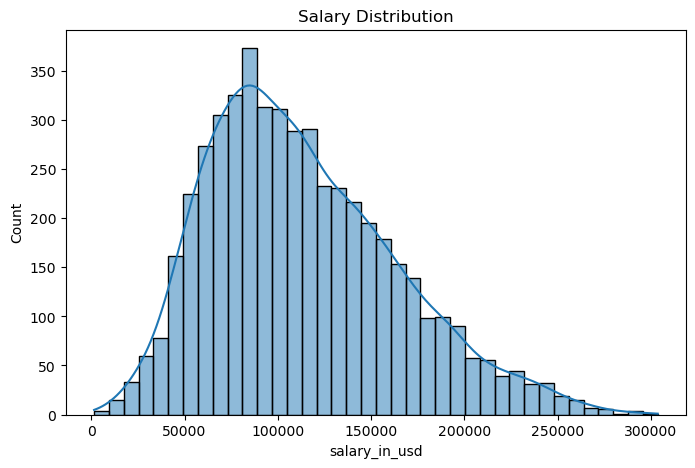

In [8]:
plt.figure(figsize=(8,5))
sns.histplot(data["salary_in_usd"], kde=True)
plt.title("Salary Distribution")
plt.show()

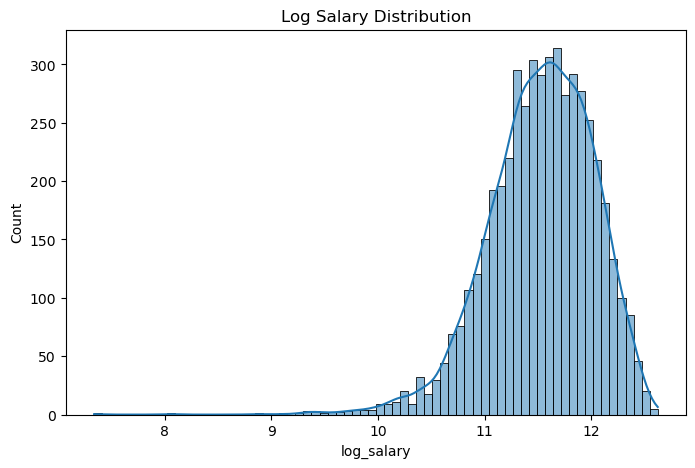

In [9]:
data["log_salary"] = np.log1p(data["salary_in_usd"])

plt.figure(figsize=(8,5))
sns.histplot(data["log_salary"], kde=True)
plt.title("Log Salary Distribution")
plt.show()

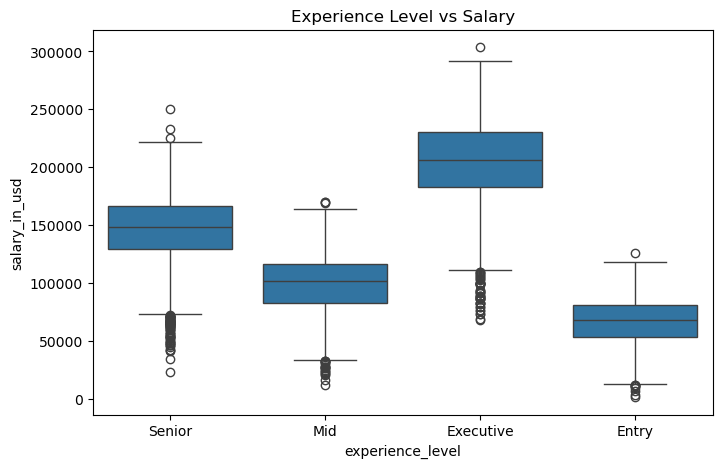

In [10]:
plt.figure(figsize=(8,5))
sns.boxplot(x="experience_level", y="salary_in_usd", data=data)
plt.title("Experience Level vs Salary")
plt.show()

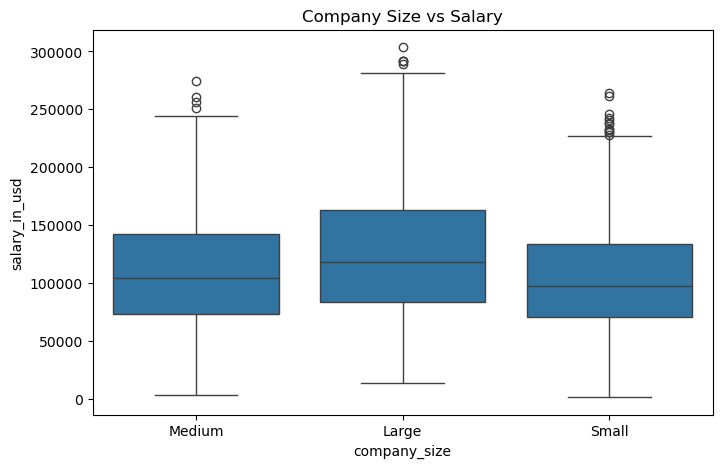

In [11]:
plt.figure(figsize=(8,5))
sns.boxplot(x="company_size", y="salary_in_usd", data=data)
plt.title("Company Size vs Salary")
plt.show()

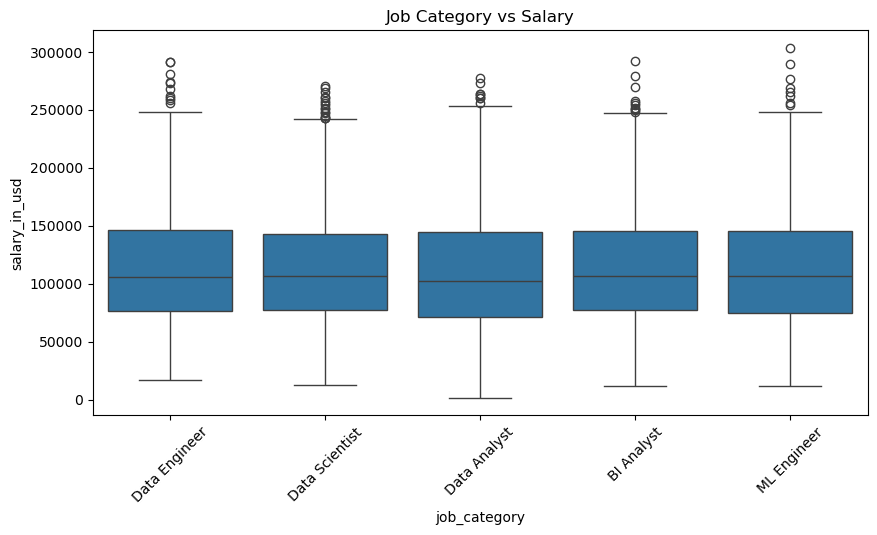

In [13]:
plt.figure(figsize=(10,5))
sns.boxplot(x="job_category", y="salary_in_usd", data=data)
plt.xticks(rotation=45)
plt.title("Job Category vs Salary")
plt.show()

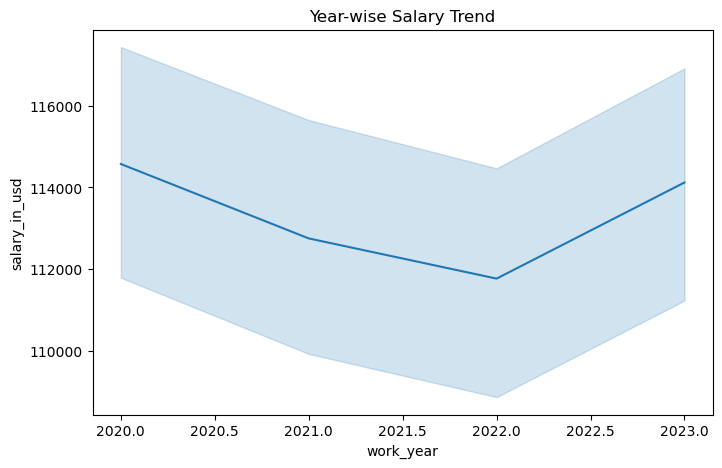

In [14]:
plt.figure(figsize=(8,5))
sns.lineplot(x="work_year", y="salary_in_usd", data=data)
plt.title("Year-wise Salary Trend")
plt.show()

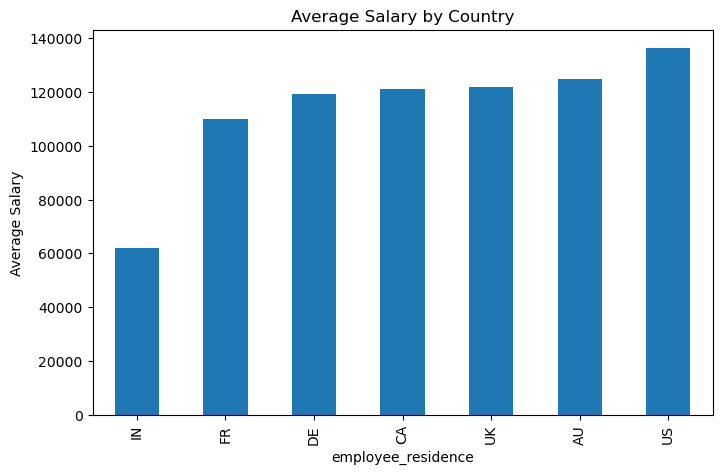

In [15]:
plt.figure(figsize=(8,5))
data.groupby("employee_residence")["salary_in_usd"].mean().sort_values().plot(kind="bar")
plt.title("Average Salary by Country")
plt.ylabel("Average Salary")
plt.show()

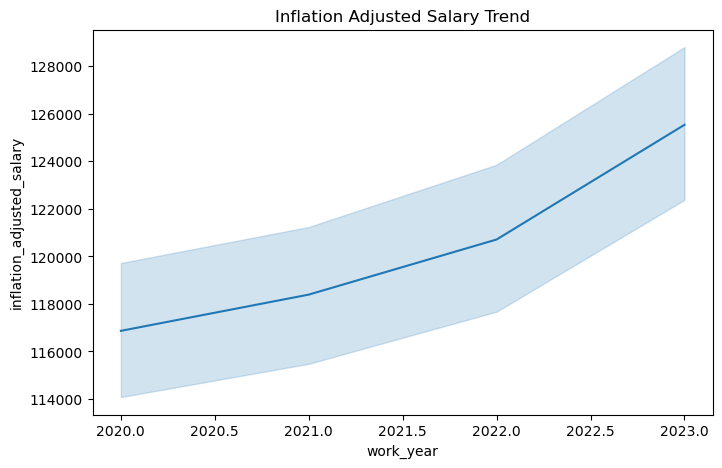

In [16]:
inflation = {2020:1.02, 2021:1.05, 2022:1.08, 2023:1.10}

data["inflation_adjusted_salary"] = data.apply(
    lambda row: row["salary_in_usd"] * inflation[row["work_year"]],
    axis=1
)

plt.figure(figsize=(8,5))
sns.lineplot(x="work_year", y="inflation_adjusted_salary", data=data)
plt.title("Inflation Adjusted Salary Trend")
plt.show()

In [19]:
print(data.columns)

Index(['work_year', 'experience_level', 'employment_type', 'job_category',
       'company_size', 'remote_ratio', 'employee_residence', 'salary_in_usd_x',
       'log_salary', 'inflation_adjusted_salary', 'salary_in_usd_y',
       'geo_cluster'],
      dtype='object')


In [23]:
# Create country average salary
country_salary = data.groupby("employee_residence")["salary_in_usd_y"].mean().reset_index()

# Rename to avoid duplication
country_salary.rename(columns={"salary_in_usd_y": "country_avg_salary"}, inplace=True)

# Apply clustering on country average salary
kmeans = KMeans(n_clusters=3, random_state=42)
country_salary["geo_cluster"] = kmeans.fit_predict(country_salary[["country_avg_salary"]])

# Merge back safely
data = data.merge(country_salary, on="employee_residence", how="left")

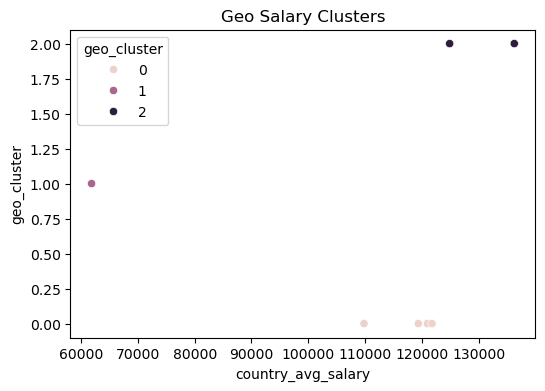

In [26]:
plt.figure(figsize=(6,4))
sns.scatterplot(
    x=country_salary["country_avg_salary"],
    y=country_salary["geo_cluster"],
    hue=country_salary["geo_cluster"]
)
plt.title("Geo Salary Clusters")
plt.show()

In [27]:
data_encoded = pd.get_dummies(data, drop_first=True)

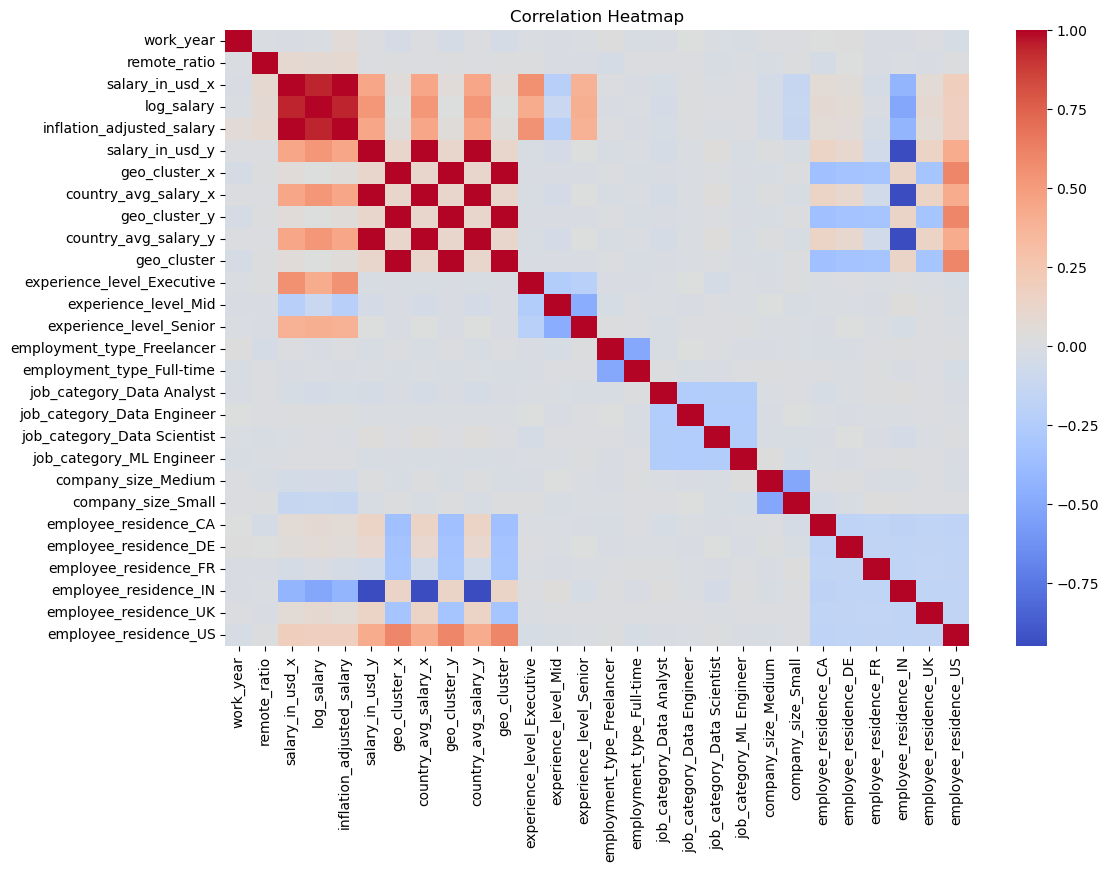

In [28]:
plt.figure(figsize=(12,8))
sns.heatmap(data_encoded.corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [30]:
X = data_encoded.drop(["salary_in_usd_y","log_salary"], axis=1)
y = data_encoded["log_salary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [31]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)

gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train,y_train)
gb_pred = gb.predict(X_test)

xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
xgb.fit(X_train,y_train)
xgb_pred = xgb.predict(X_test)

In [32]:
def evaluate(name, y_test, pred):
    print(name)
    print("R2:", r2_score(y_test,pred))
    print("MAE:", mean_absolute_error(y_test,pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test,pred)))
    print("---------------")

evaluate("Random Forest", y_test, rf_pred)
evaluate("Gradient Boosting", y_test, gb_pred)
evaluate("XGBoost", y_test, xgb_pred)

Random Forest
R2: 0.9998797148297282
MAE: 0.0007519654560124476
RMSE: 0.0056080017034933665
---------------
Gradient Boosting
R2: 0.9978574750422234
MAE: 0.0047699209908908255
RMSE: 0.023668189512450442
---------------
XGBoost
R2: 0.982547097934827
MAE: 0.005974366933983234
RMSE: 0.06755164340819515
---------------


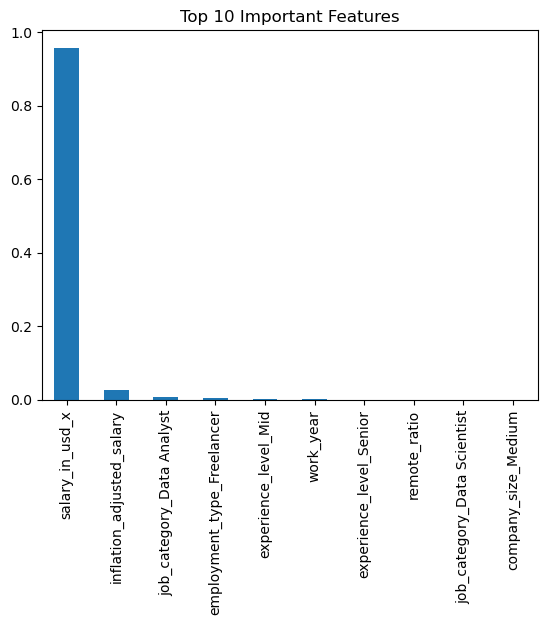

In [33]:
importance = pd.Series(xgb.feature_importances_, index=X.columns)
importance.sort_values(ascending=False).head(10).plot(kind="bar")
plt.title("Top 10 Important Features")
plt.show()

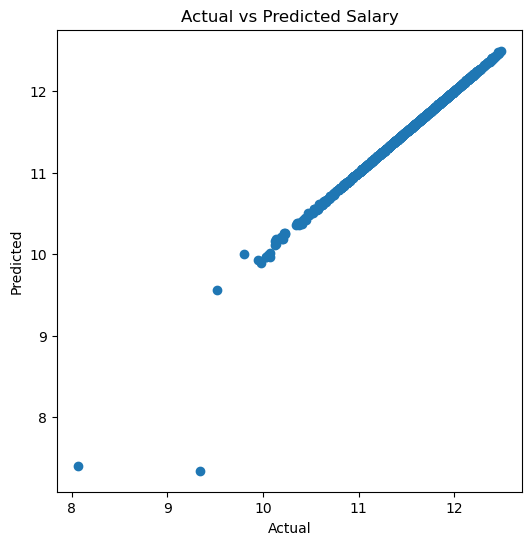

In [34]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, xgb_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Salary")
plt.show()

In [35]:
new_employee = X_test.iloc[0:1]
prediction = xgb.predict(new_employee)
print("Predicted Log Salary:", prediction)

Predicted Log Salary: [11.942045]


In [37]:
# ======================================
# INTERACTIVE SALARY PREDICTION SYSTEM
# ======================================

print("\n======= DATA SCIENCE SALARY PREDICTION SYSTEM =======\n")

# Take user inputs
work_year = int(input("Enter Work Year (2020-2023): "))
experience_level = input("Enter Experience Level (Entry/Mid/Senior/Executive): ")
employment_type = input("Enter Employment Type (Full-time/Contract/Freelancer): ")
job_category = input("Enter Job Category (Data Scientist/Data Engineer/ML Engineer/Data Analyst/BI Analyst): ")
company_size = input("Enter Company Size (Small/Medium/Large): ")
remote_ratio = int(input("Enter Remote Ratio (0/50/100): "))
employee_residence = input("Enter Country (US/UK/IN/DE/CA/FR/AU): ")

# Create DataFrame
user_input = pd.DataFrame([{
    "work_year": work_year,
    "experience_level": experience_level,
    "employment_type": employment_type,
    "job_category": job_category,
    "company_size": company_size,
    "remote_ratio": remote_ratio,
    "employee_residence": employee_residence
}])

# Merge geo cluster info
user_input = user_input.merge(country_salary, on="employee_residence", how="left")

# One-hot encode
user_encoded = pd.get_dummies(user_input)

# Align with training columns
user_encoded = user_encoded.reindex(columns=X.columns, fill_value=0)

# Predict
predicted_log_salary = xgb.predict(user_encoded)
predicted_salary = np.expm1(predicted_log_salary)

print("\nEstimated Salary (USD):", round(predicted_salary[0], 2))
print("\n====================================================")


======= DATA SCIENCE SALARY PREDICTION SYSTEM =======



Enter Work Year (2020-2023):  2021
Enter Experience Level (Entry/Mid/Senior/Executive):  mid
Enter Employment Type (Full-time/Contract/Freelancer):  contract
Enter Job Category (Data Scientist/Data Engineer/ML Engineer/Data Analyst/BI Analyst):  data engineer
Enter Company Size (Small/Medium/Large):  small
Enter Remote Ratio (0/50/100):  50
Enter Country (US/UK/IN/DE/CA/FR/AU):  uk



Estimated Salary (USD): 12779.93

